In [1]:
from pathlib import Path
import torch
import os
import SimpleITK as sitk
from convexAdam.convex_adam_MIND import convex_adam_pt
from convexAdam.apply_convex import apply_convex
import numpy as np
from convexAdam.convex_adam_utils import (resample_img,
                                          resample_moving_to_fixed)

In [2]:

def configure_torch_settings():
    """配置PyTorch的确定性参数"""
    torch.backends.cuda.matmul.allow_tf32 = False
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms(True, warn_only=True)

def load_dicom_series(dicom_dir, series_name):
    """加载DICOM序列"""
    reader = sitk.ImageSeriesReader()
    dicom_files = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(
        os.path.join(dicom_dir, series_name)
    )
    reader.SetFileNames(dicom_files)
    
    return reader.Execute()

def load_nii(nii_dir):
    return sitk.ReadImage(nii_dir)

def perform_registration(fixed_img, moving_img):
    """执行图像配准"""
    # #小网格间距
    # return convex_adam_pt(
    #     img_fixed=fixed_img,
    #     img_moving=moving_img,
    #     dtype=torch.float64
    # )
    #大网格间距
    return convex_adam_pt(
        img_fixed=fixed_img,
        img_moving=moving_img,
        dtype=torch.float64,
        selected_niter=160,  # 减少初始迭代次数
        mind_d=8,  # 增大特征距离
        mind_r=4,  # 增大特征半径
        disp_hw=16,  # 增大位移搜索范围
        grid_sp=12,  # 使用更大网格间距
        lambda_weight=0.5,  # 降低形变场约束
        selected_smooth=5,  # 增强平滑
        ic=True,
    )
    
    ##中网格间距
    # return convex_adam_pt(
    #     img_fixed=fixed_img,
    #     img_moving=moving_img,  
    #     dtype=torch.float64,
    #     selected_niter=300, 
    #     mind_d=4,
    #     mind_r=2,
    #     disp_hw=8,
    #     grid_sp=9,
    #     lambda_weight=1.5,
    #     selected_smooth=0,
    #     ic=True,
    # )

def calculate_tumor_position(fixed_image, displacementfield,scale_factor,input_point, patch_size,return_physical_point):

    z1,y1,x1=input_point
    
    half_size_x, half_size_y, half_size_z = patch_size[2]//2, patch_size[1]//2, patch_size[0]//2
 

    # 从形变场中读取位移量
    """
    这里由于convexadam源码的问题, 需要注意:
    1.一般的形变场位移量单位为mm, 但这里输出的单位是pixel
    2.一般的形变场位移量的第3维是以xyz顺序排列, 这里是以zyx顺序排列
    
    一般模型array是以DWH输入, 但源码是以HWD输入
    因此在不改变源码和输入数据的基础上，

    1.将输出的单位转换为mm
    2.将第三维输出以zyx顺序排列
    """
    dx_ras = displacementfield [half_size_z, half_size_y, half_size_x , 2]/scale_factor[2]
    dy_ras = displacementfield [half_size_z, half_size_y, half_size_x , 1]/scale_factor[1]
    dz_ras = displacementfield [half_size_z, half_size_y, half_size_x , 0]/scale_factor[0]
    print('dx_ras,dy_ras,dz_ras',dx_ras,dy_ras,dz_ras)
    
    moving_tumor_voxel = [ round(z1+dz_ras),round(y1+dy_ras), round(x1+dx_ras)]

    moving_tumor_physical_point = fixed_image.TransformIndexToPhysicalPoint((moving_tumor_voxel[2],moving_tumor_voxel[1],moving_tumor_voxel[0]))
    
    if return_physical_point:
        return [moving_tumor_physical_point[2],moving_tumor_physical_point[1],moving_tumor_physical_point[0]]
    else:
        return moving_tumor_voxel

def input_point_cal(img,scale_factor,input_point, input_physical_point):
    if input_physical_point:
        ori_center = img.TransformPhysicalPointToIndex((input_point[2],input_point[1],input_point[0]))
        #这里ori返回的是xyz
        ori_center= [ori_center[2],ori_center[1],ori_center[0]]
        resample_center=[
            round(ori_center[0]*scale_factor[0]),
            round(ori_center[1]*scale_factor[1]),
            round(ori_center[2]*scale_factor[2]),
        ]
    else:
        ori_center = input_point

        resample_center=[
            round(input_point[0]*scale_factor[0]),
            round(input_point[1]*scale_factor[1]),
            round(input_point[2]*scale_factor[2]),
        ]

    return ori_center,resample_center

def get_patch(sitk_image, resample_center, patch_size):
    """
    从图像中获取指定中心和大小的patch
    """
    sitk_image_arr =  sitk.GetArrayFromImage(sitk_image)
    print('sitk_image_arr.shape',sitk_image_arr.shape)
    
    z,y,x = resample_center
    
    print('z,y,x',z,y,x)

    # 计算裁剪区域
    start_z =  z - patch_size[0]//2
    end_z = start_z + patch_size[0]
    start_y =  y - patch_size[1]//2
    end_y = start_y + patch_size[1]
    start_x = x - patch_size[2]//2
    end_x = start_x + patch_size[2]
    print('start_z,end_z,start_y,end_y,start_x,end_x',start_z,end_z,start_y,end_y,start_x,end_x)
    
    pad_x_start,pad_y_start,pad_z_start=0,0,0
    pad_x_end,pad_y_end,pad_z_end=patch_size[2],patch_size[1],patch_size[0]
    
    if start_z < 0:

        pad_z_start=abs(start_z)
        start_z=0
    if start_y < 0:

        pad_y_start=abs(start_y)
        start_y=0
    if start_x < 0:

        pad_x_start=abs(start_x)
        start_x=0

    if end_z > sitk_image_arr.shape[0]:
        pad_z_end=patch_size[0]-(end_z-sitk_image_arr.shape[0])
        end_z=sitk_image_arr.shape[0]
        
        
    if end_y > sitk_image_arr.shape[1]:
        pad_y_end=patch_size[1]-(end_y-sitk_image_arr.shape[1])
        end_y=sitk_image_arr.shape[1]
        
        
    if end_x > sitk_image_arr.shape[2]:
        pad_x_end=patch_size[2]-(end_x-sitk_image_arr.shape[2])
        end_x=sitk_image_arr.shape[2]
        
    
    print('start_z,end_z,start_y,end_y,start_x,end_x',start_z,end_z,start_y,end_y,start_x,end_x)
    print('pad_z_start,pad_z_end,pad_y_start,pad_y_end,pad_x_start,pad_x_end',pad_z_start,pad_z_end,pad_y_start,pad_y_end,pad_x_start,pad_x_end)
     # 执行裁剪
    
    cropped=np.zeros((patch_size[0],patch_size[1],patch_size[2]))
    
    cropped[pad_z_start:pad_z_end, pad_y_start:pad_y_end, pad_x_start:pad_x_end] =sitk_image_arr[start_z:end_z, start_y:end_y, start_x:end_x]
    
    patch=sitk.GetImageFromArray(cropped)
    patch.SetSpacing(sitk_image.GetSpacing())
    patch.SetOrigin(sitk_image.GetOrigin())
    patch.SetDirection(sitk_image.GetDirection())

    return patch

In [3]:

# 配置参数
config = {
    "input_dir": r"D:\project\data\术中磁共振\6\sorted_new",
    "fixed_series": r"201000\0",
    "moving_series": r"301000\0",
    "subject_id": "6_201000_301000",
    "fixed_point": [ 22,256,195], #zyx
    "input_physical_point": False,
    "return_physical_point":False,
    "patch_size": [64,64,64], #zyx
    "resample_spacing": [1,1,1], #zyx
    "GT_point": [17,248,208],    #zyx
}

configure_torch_settings()




In [4]:


# 加载图像数据
fixed_image = load_dicom_series(config["input_dir"], config["fixed_series"])
moving_image = load_dicom_series(config["input_dir"], config["moving_series"])
print(fixed_image.GetSize())
print(moving_image.GetSize())
print(fixed_image.GetSpacing())
print(moving_image.GetSpacing())
print(fixed_image.GetOrigin())
print(moving_image.GetOrigin())
print(fixed_image.GetDirection())
print(moving_image.GetDirection())


(704, 704, 30)
(704, 704, 30)
(0.539773, 0.539773, 2.49999999999998)
(0.539773, 0.539773, 2.49999999999998)
(-183.20557796955, -250.03592264652, -71.893692016601)
(-183.20557796955, -250.03592264652, -71.893692016601)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)


In [ ]:

#转成物理坐标验证 输出的oricenter是原本的值就是正确的
new_point = fixed_image.TransformIndexToPhysicalPoint((config["fixed_point"][2],config["fixed_point"][1],config["fixed_point"][0]))
config["fixed_point"]=[new_point[2],new_point[1],new_point[0]]
print(config["fixed_point"])
config["input_physical_point"] =True

scale_factor=[fixed_image.GetSpacing()[2]/config["resample_spacing"][0],
              fixed_image.GetSpacing()[1]/config["resample_spacing"][1],
              fixed_image.GetSpacing()[0]/config["resample_spacing"][2]]
print('scale_factor:',scale_factor)

ori_center,resample_center=input_point_cal(fixed_image,scale_factor,config["fixed_point"],config["input_physical_point"])
print('ori_center:', ori_center)
print('resample_center:', resample_center)



[-16.893692016601435, -111.85403464652, -77.94984296955002]
scale_factor: [2.49999999999998, 0.539773, 0.539773]
ori_center: [22, 256, 195]
resample_center: [55, 138, 105]


In [6]:


fixed_image_resample=resample_img(fixed_image, config["resample_spacing"])
moving_image_resample=resample_moving_to_fixed(fixed_image_resample,moving_image)

sitk.WriteImage(fixed_image_resample, os.path.join("result", config["subject_id"]+"_fixed_resample.nii.gz"))
sitk.WriteImage(moving_image_resample, os.path.join("result", config["subject_id"]+"_moving_resample.nii.gz"))
print(fixed_image_resample.GetSize())
print(moving_image_resample.GetSize())
print(fixed_image_resample.GetSpacing())
print(moving_image_resample.GetSpacing())
print(fixed_image_resample.GetOrigin())
print(moving_image_resample.GetOrigin())
print(fixed_image_resample.GetDirection())
print(moving_image_resample.GetDirection())


fixed_image_patch=get_patch(
    fixed_image_resample,
    resample_center,
    patch_size=config["patch_size"]
)

moving_image_patch=get_patch(     
    moving_image_resample,
    resample_center,
    patch_size=config["patch_size"]
    )

print(fixed_image_patch.GetSize())
print(moving_image_patch.GetSize())
print(fixed_image_patch.GetSpacing())
print(moving_image_patch.GetSpacing())
print(fixed_image_patch.GetOrigin())
print(moving_image_patch.GetOrigin())
print(fixed_image_patch.GetDirection())
print(moving_image_patch.GetDirection())



sitk.WriteImage(fixed_image_patch, os.path.join("result",config["subject_id"]+"_fixed_image_patch.nii.gz"))
sitk.WriteImage(moving_image_patch, os.path.join("result",config["subject_id"]+"_moving_image_patch.nii.gz"))


(380, 380, 75)
(380, 380, 75)
(1.0, 1.0, 1.0)
(1.0, 1.0, 1.0)
(-183.20557796955, -250.03592264652, -71.893692016601)
(-183.20557796955, -250.03592264652, -71.893692016601)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
sitk_image_arr.shape (75, 380, 380)
z,y,x 55 138 105
start_z,end_z,start_y,end_y,start_x,end_x 23 87 106 170 73 137
start_z,end_z,start_y,end_y,start_x,end_x 23 75 106 170 73 137
pad_z_start,pad_z_end,pad_y_start,pad_y_end,pad_x_start,pad_x_end 0 52 0 64 0 64
sitk_image_arr.shape (75, 380, 380)
z,y,x 55 138 105
start_z,end_z,start_y,end_y,start_x,end_x 23 87 106 170 73 137
start_z,end_z,start_y,end_y,start_x,end_x 23 75 106 170 73 137
pad_z_start,pad_z_end,pad_y_start,pad_y_end,pad_x_start,pad_x_end 0 52 0 64 0 64
(64, 64, 64)
(64, 64, 64)
(1.0, 1.0, 1.0)
(1.0, 1.0, 1.0)
(-183.20557796955, -250.03592264652, -71.893692016601)
(-183.20557796955, -250.03592264652, -71.893692016601)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
(1

In [7]:

# 执行配准
displacement= perform_registration(fixed_image_patch ,moving_image_patch)


In [8]:

# 计算肿瘤位置
result = calculate_tumor_position(
    fixed_image,
    displacement,
    scale_factor,
    ori_center,
    config["patch_size"],
    return_physical_point=config["return_physical_point"],
)

print('original_point:',config['fixed_point'])
if config["return_physical_point"]:
    print(f"Moving Image Coordinate (physical): {result}")
else:
    print(f"Moving Image Coordinate (index): {result}")
print('GT should be:',config['GT_point'])



dx_ras,dy_ras,dz_ras 10.347804412620452 -5.7920794484499485 -4.227125167846713
original_point: [-16.893692016601435, -111.85403464652, -77.94984296955002]
Moving Image Coordinate (index): [18, 250, 205]
GT should be: [17, 248, 208]


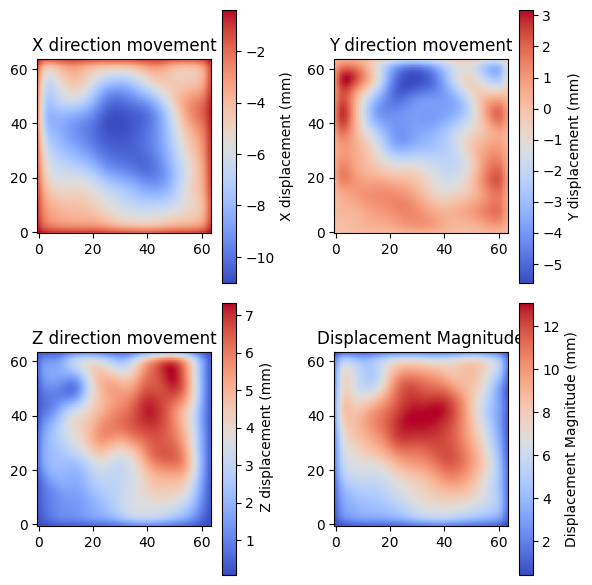

In [9]:
import matplotlib.pyplot as plt

disp_arr=displacement


# 选择中间层显示
z_center = disp_arr.shape[0] // 2

# 创建带方向箭头的可视化
plt.figure(figsize=(6,6))

# X方向位移分量
plt.subplot(221)
plt.imshow(disp_arr[z_center,:,:,0], cmap='coolwarm', origin='lower')
plt.colorbar(label='X displacement (mm)')
plt.title('X direction movement')

# Y方向位移分量
plt.subplot(222)
plt.imshow(disp_arr[z_center,:,:,1], cmap='coolwarm', origin='lower')
plt.colorbar(label='Y displacement (mm)')
plt.title('Y direction movement')

# Z方向位移分量
plt.subplot(223)
plt.imshow(disp_arr[z_center,:,:,2], cmap='coolwarm', origin='lower')
plt.colorbar(label=' Z displacement (mm)')
plt.title('Z direction movement')


# 位移幅值
plt.subplot(224)
magnitude = np.sqrt(np.sum(disp_arr**2, axis=3))
plt.imshow(magnitude[z_center], cmap='coolwarm', origin='lower')
plt.colorbar(label='Displacement Magnitude (mm)')
plt.title('Displacement Magnitude')

plt.tight_layout()
plt.show()


In [10]:

deformation_field = sitk.GetImageFromArray(displacement)

# 读取形变
deformation_field.CopyInformation(fixed_image_patch)  # 同步原点、间距、方向
sitk.WriteImage(deformation_field, os.path.join("result", config["subject_id"]+"_displacement.nii.gz"))



In [11]:

# apply displacement field
moving_image_warped = apply_convex(
    disp=displacement,
    moving=moving_image_patch,
)

# convert to SimpleITK image
moving_image_warped = sitk.GetImageFromArray(moving_image_warped)
moving_image_warped.CopyInformation(moving_image_patch)
sitk.WriteImage(moving_image_warped, os.path.join("result", config["subject_id"]+"_moving_image_warped.nii.gz"))



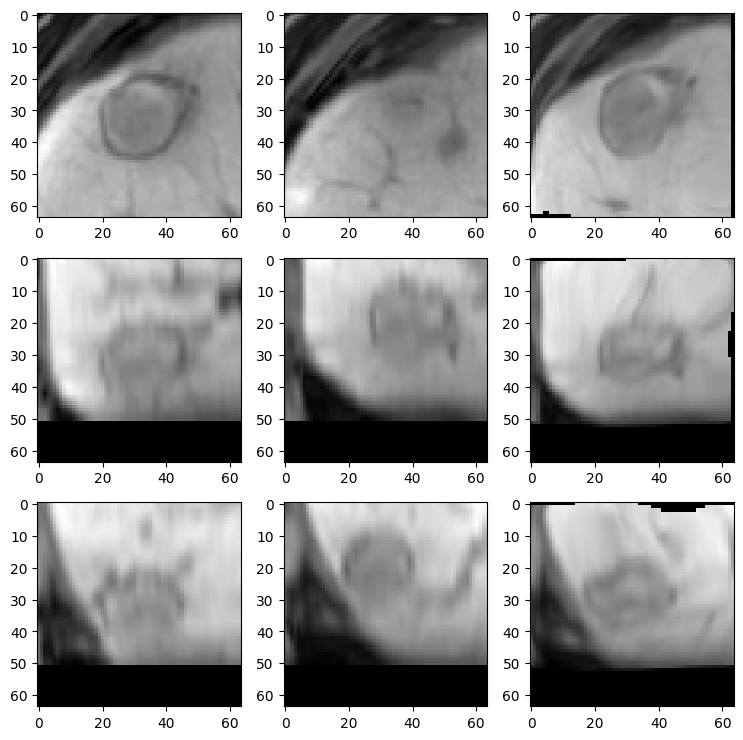

In [12]:

#show fixed_image_patch
import matplotlib.pyplot as plt
plt.figure(figsize=(9,9))
plt.subplot(3,3,1)
plt.imshow(sitk.GetArrayFromImage(fixed_image_patch)[config['patch_size'][0]//2,:,:],cmap="gray")
plt.subplot(3,3,2)
plt.imshow(sitk.GetArrayFromImage(moving_image_patch)[config['patch_size'][0]//2,:,:],cmap="gray")
plt.subplot(3,3,3)
plt.imshow(sitk.GetArrayFromImage(moving_image_warped)[config['patch_size'][0]//2,:,:],cmap="gray")

plt.subplot(3,3,4)
plt.imshow(sitk.GetArrayFromImage(fixed_image_patch)[:,config['patch_size'][1]//2,:],cmap="gray")
plt.subplot(3,3,5)
plt.imshow(sitk.GetArrayFromImage(moving_image_patch)[:,config['patch_size'][1]//2,:],cmap="gray")
plt.subplot(3,3,6)
plt.imshow(sitk.GetArrayFromImage(moving_image_warped)[:,config['patch_size'][1]//2,:],cmap="gray")

plt.subplot(3,3,7)
plt.imshow(sitk.GetArrayFromImage(fixed_image_patch)[:,:,config['patch_size'][2]//2],cmap="gray")
plt.subplot(3,3,8)
plt.imshow(sitk.GetArrayFromImage(moving_image_patch)[:,:,config['patch_size'][2]//2],cmap="gray")
plt.subplot(3,3,9)
plt.imshow(sitk.GetArrayFromImage(moving_image_warped)[:,:,config['patch_size'][2]//2],cmap="gray")




plt.show()


sitk_image_arr.shape (75, 380, 380)
z,y,x 42 134 112
start_z,end_z,start_y,end_y,start_x,end_x 10 74 102 166 80 144
start_z,end_z,start_y,end_y,start_x,end_x 10 74 102 166 80 144
pad_z_start,pad_z_end,pad_y_start,pad_y_end,pad_x_start,pad_x_end 0 64 0 64 0 64


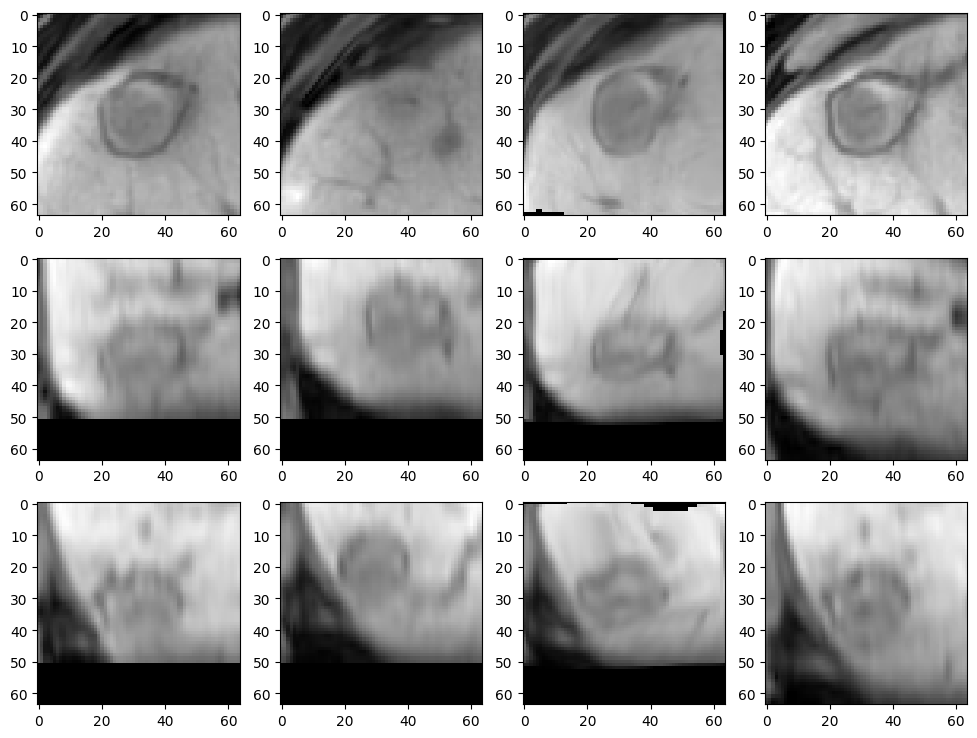

MSD_value: 53833.14757537842
NCC_value: 0.39730624708733125
MI_value: 378.3383537890083
NMI_value: 0.950251150973377
-----------------------------------------------------------
MSD_value_pred: 48150.99665951471
NCC_value_pred: 0.3464428410060184
MI_value_pred: 385.90433360628367
NMI_value_pred: 0.9548046894649345
-----------------------------------------------------------
MSD_value_GT: 53045.95655822754
NCC_value_GT: 0.4957916127705327
MI_value_GT: 383.4409233679736
NMI_value_GT: 0.9466036276543859


In [13]:
#计算MSD，NCC，MI，NMI指标
def MSD(img1,img2):
    return np.mean((img1-img2)**2)

def NCC(img1,img2):
    return np.mean((img1-img2)*(img1-img2))/(np.std(img1)*np.std(img2))

def MI(img1,img2):
    return np.sum(img1*img2)/np.sum(img1+img2)

def NMI(img1,img2):
    return 2*MI(img1,img2)/(MI(img1,img1)+MI(img2,img2))



fixed_image_patch_arr=sitk.GetArrayFromImage(fixed_image_patch)
moving_image_patch_arr=sitk.GetArrayFromImage(moving_image_patch)
moving_image_warped_arr=sitk.GetArrayFromImage(moving_image_warped)

GT_center,resample_GT_center=input_point_cal(moving_image,scale_factor,config["GT_point"],input_physical_point=False)

GT_patch=get_patch(     
    moving_image_resample,
    resample_GT_center,
    patch_size=config["patch_size"]
    )

GT_patch_arr=sitk.GetArrayFromImage(GT_patch)



import matplotlib.pyplot as plt
plt.figure(figsize=(12,9))
plt.subplot(3,4,1)
plt.imshow(sitk.GetArrayFromImage(fixed_image_patch)[config['patch_size'][0]//2,:,:],cmap="gray")
plt.subplot(3,4,2)
plt.imshow(sitk.GetArrayFromImage(moving_image_patch)[config['patch_size'][0]//2,:,:],cmap="gray")
plt.subplot(3,4,3)
plt.imshow(sitk.GetArrayFromImage(moving_image_warped)[config['patch_size'][0]//2,:,:],cmap="gray")
plt.subplot(3,4,4)
plt.imshow(sitk.GetArrayFromImage(GT_patch)[config['patch_size'][0]//2,:,:],cmap="gray")

plt.subplot(3,4,5)
plt.imshow(sitk.GetArrayFromImage(fixed_image_patch)[:,config['patch_size'][1]//2,:],cmap="gray")
plt.subplot(3,4,6)
plt.imshow(sitk.GetArrayFromImage(moving_image_patch)[:,config['patch_size'][1]//2,:],cmap="gray")
plt.subplot(3,4,7)
plt.imshow(sitk.GetArrayFromImage(moving_image_warped)[:,config['patch_size'][1]//2,:],cmap="gray")
plt.subplot(3,4,8)
plt.imshow(sitk.GetArrayFromImage(GT_patch)[:,config['patch_size'][1]//2,:],cmap="gray")

plt.subplot(3,4,9)
plt.imshow(sitk.GetArrayFromImage(fixed_image_patch)[:,:,config['patch_size'][2]//2],cmap="gray")
plt.subplot(3,4,10)
plt.imshow(sitk.GetArrayFromImage(moving_image_patch)[:,:,config['patch_size'][2]//2],cmap="gray")
plt.subplot(3,4,11)
plt.imshow(sitk.GetArrayFromImage(moving_image_warped)[:,:,config['patch_size'][2]//2],cmap="gray")
plt.subplot(3,4,12)
plt.imshow(sitk.GetArrayFromImage(GT_patch)[:,:,config['patch_size'][2]//2],cmap="gray")

plt.show()

MSD_value=  MSD(fixed_image_patch_arr,moving_image_patch_arr)
NCC_value=NCC(fixed_image_patch_arr,moving_image_patch_arr)
MI_value=MI(fixed_image_patch_arr,moving_image_patch_arr)
NMI_value=NMI(fixed_image_patch_arr,moving_image_patch_arr)
print('MSD_value:',MSD_value)
print('NCC_value:',NCC_value)
print('MI_value:',MI_value)
print('NMI_value:',NMI_value)
print('-----------------------------------------------------------')
MSD_value_pred=MSD(fixed_image_patch_arr,moving_image_warped_arr)
NCC_value_pred=NCC(fixed_image_patch_arr,moving_image_warped_arr)
MI_value_pred=MI(fixed_image_patch_arr,moving_image_warped_arr)
NMI_value_pred=NMI(fixed_image_patch_arr,moving_image_warped_arr)
print('MSD_value_pred:',MSD_value_pred)
print('NCC_value_pred:',NCC_value_pred)
print('MI_value_pred:',MI_value_pred)
print('NMI_value_pred:',NMI_value_pred)
print('-----------------------------------------------------------')
MSD_value_GT=MSD(fixed_image_patch_arr,GT_patch_arr)
NCC_value_GT=NCC(fixed_image_patch_arr,GT_patch_arr)
MI_value_GT=MI(fixed_image_patch_arr,GT_patch_arr)
NMI_value_GT=NMI(fixed_image_patch_arr,GT_patch_arr)
print('MSD_value_GT:',MSD_value_GT)
print('NCC_value_GT:',NCC_value_GT)
print('MI_value_GT:',MI_value_GT)
print('NMI_value_GT:',NMI_value_GT)

sitk_image_arr.shape (75, 380, 380)
z,y,x 55 138 105
start_z,end_z,start_y,end_y,start_x,end_x 23 87 106 170 73 137
start_z,end_z,start_y,end_y,start_x,end_x 23 75 106 170 73 137
pad_z_start,pad_z_end,pad_y_start,pad_y_end,pad_x_start,pad_x_end 0 52 0 64 0 64
sitk_image_arr.shape (75, 380, 380)
z,y,x 45 135 111
start_z,end_z,start_y,end_y,start_x,end_x 13 77 103 167 79 143
start_z,end_z,start_y,end_y,start_x,end_x 13 75 103 167 79 143
pad_z_start,pad_z_end,pad_y_start,pad_y_end,pad_x_start,pad_x_end 0 62 0 64 0 64


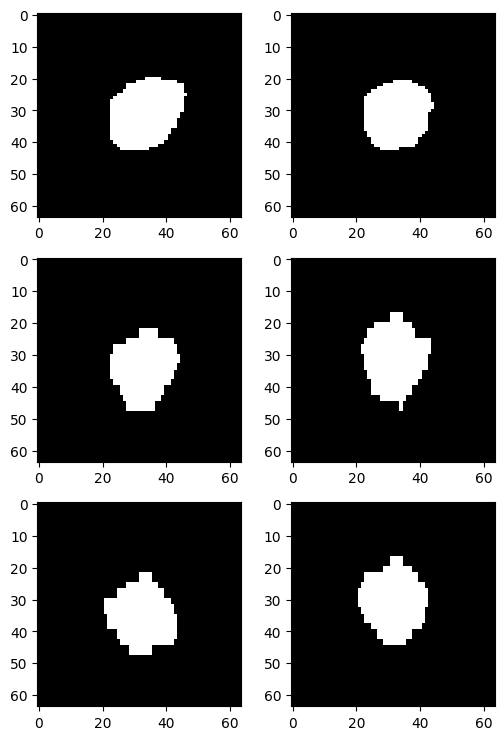

MSD_value_mask: 0.011646270751953125
NCC_value_mask: 0.49001885822412194
MI_value_mask: 0.38050880626223094
NMI_value_mask: 0.7610176125244619
Dice: 0.7610363180964308


In [14]:
fixed_mask_path=r'result\6_201000_fixed_mask.nii.gz'
moving_mask_path=r'result\6_301000_moving_mask.nii.gz'
fixed_mask=load_nii(fixed_mask_path)
moving_mask=load_nii(moving_mask_path)

fixed_mask_center,resample_fixed_mask_center=input_point_cal(fixed_image,scale_factor,config["fixed_point"],config["input_physical_point"])
moving_mask_center,resample_moving_mask_center=input_point_cal(moving_image,scale_factor,result,config["return_physical_point"])

fixed_mask_resample=resample_img(fixed_mask, config["resample_spacing"])
moving_mask_resample=resample_moving_to_fixed(fixed_mask_resample,moving_mask)

#计算MSD，NCC，MI，NMI指标
def MSD(img1,img2):
    return np.mean((img1-img2)**2)

def NCC(img1,img2):
    return np.mean((img1-img2)*(img1-img2))/(np.std(img1)*np.std(img2))

def MI(img1,img2):
    return np.sum(img1*img2)/np.sum(img1+img2)

def NMI(img1,img2):
    return 2*MI(img1,img2)/(MI(img1,img1)+MI(img2,img2))


fixed_mask_patch=get_patch(     
    fixed_mask_resample,
    resample_fixed_mask_center,
    patch_size=config["patch_size"]
    )
moving_mask_patch=get_patch(
    moving_mask_resample,
    resample_moving_mask_center,
    patch_size=config["patch_size"]
    ) 

fixed_mask_patch_arr=sitk.GetArrayFromImage(fixed_mask_patch)
moving_mask_patch_arr=sitk.GetArrayFromImage(moving_mask_patch)

import matplotlib.pyplot as plt
plt.figure(figsize=(6,9))
plt.subplot(3,2,1)
plt.imshow(fixed_mask_patch_arr[config['patch_size'][0]//2,:,:],cmap="gray")
plt.subplot(3,2,2)
plt.imshow(moving_mask_patch_arr[config['patch_size'][0]//2,:,:],cmap="gray")
plt.subplot(3,2,3)
plt.imshow(fixed_mask_patch_arr[:,config['patch_size'][1]//2,:],cmap="gray")
plt.subplot(3,2,4)
plt.imshow(moving_mask_patch_arr[:,config['patch_size'][1]//2,:],cmap="gray")
plt.subplot(3,2,5)
plt.imshow(fixed_mask_patch_arr[:,:,config['patch_size'][2]//2],cmap="gray")
plt.subplot(3,2,6)
plt.imshow(moving_mask_patch_arr[:,:,config['patch_size'][2]//2],cmap="gray")
plt.show()


MSD_value_mask=MSD(fixed_mask_patch_arr,moving_mask_patch_arr)
NCC_value_mask=NCC(fixed_mask_patch_arr,moving_mask_patch_arr)
MI_value_mask=MI(fixed_mask_patch_arr,moving_mask_patch_arr)
NMI_value_mask=NMI(fixed_mask_patch_arr,moving_mask_patch_arr)

print('MSD_value_mask:',MSD_value_mask)
print('NCC_value_mask:',NCC_value_mask)
print('MI_value_mask:',MI_value_mask)
print('NMI_value_mask:',NMI_value_mask)

def dice_score(y_true, y_pred):
    smooth = 1.0
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

Dice=dice_score(fixed_mask_patch_arr,moving_mask_patch_arr)
print('Dice:',Dice)